# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Инструкция по выполнению проекта

### 1.  Подготовьте данные
- 1.1. Откройте файлы и изучите их;
- 1.2. Проведите предобработку данных;
- 1.3. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака;
- 1.4. Проанализируйте признаки, недоступные в тестовой выборке.

### 2. Проанализируйте данные
- 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки;
- 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках;
- 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

### 3. Постройте модель
- 3.1. Напишите функцию для вычисления итоговой sMAPE;
- 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке.

# 1. Подготовка данных

## 1.1. Откройте файлы и изучите их.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.neighbors import KNeighborsRegressor as knr # На практике часто бывает, что соседние по времени параметры часто похожи.

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import warnings
import time

In [2]:
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

%matplotlib inline

In [3]:
# Стало известно, что в датасетах много столбцов, поэтому пропишем для display лимит по столбцам
pd.options.display.max_columns = 100

gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
# Напимеш вспомогательные функции для упрощения вывода (DRY)

# Базовая информация по df
def df_info(df):
    df.info()
    display(df.head())
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')


def nulls(df, column):
    return df[column].isnull().sum() / df[columns].count().sum()

In [5]:
df_info(gold_recovery_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Кол-во дубликатов: 0


*Как видим пропуски присутствуют. Датасет содержит 16 860 строк и 87 столбцов*

In [6]:
df_info(gold_recovery_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

Кол-во дубликатов: 0


*Здесь также присутствуют пропуски. Датасет содержит 5 856 строк и 53 столбца*

In [7]:
df_info(gold_recovery_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Кол-во дубликатов: 0


*Снова видим пропуски. Датасет содержит 22 716 строк и 87 столбцов*

### Описание данных

#### Технологический процесс
    - Rougher feed — исходное сырье
    - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
    - Rougher process (англ. «грубый процесс») — флотация
    - Rougher tails — отвальные хвосты
    - Float banks — флотационная установка
    - Cleaner process — очистка
    - Rougher Au — черновой концентрат золота
    - Final Au — финальный концентрат золота

#### Параметры этапов
    - air amount — объём воздуха
    - fluid levels — уровень жидкости
    - feed size — размер гранул сырья
    - feed rate — скорость подачи
    - Наименование признаков

#### Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

#### Возможные значения для блока [этап]:
    - rougher — флотация
    - primary_cleaner — первичная очистка
    - secondary_cleaner — вторичная очистка
    - final — финальные характеристики

#### Возможные значения для блока [тип_параметра]:
    - input — параметры сырья
    - output — параметры продукта
    - state — параметры, характеризующие текущее состояние этапа
    - calculation — расчётные характеристики

#### Целевые признаки:
    - rougher.output.recovery - эффективность обогащения чернового концентрата;
    - final.output.recovery - эффективность обогащения финального концентрата .

### Вывод

*Взглянув на общую информацию по 3-ем датасетам, можно сделать следующие выводы:*
- *Данные представляют собой 3 выборки: обучающую, тестовую и исходные данные*
- *Они не содержат дубликатов, но содержат пропуски. Пропуски данных могут быть вызваны как ошибкой данных, так и тем, что данные показатели во времени не были измерены* 
- *В тестовой выборке отсутствуют некоторые колонки в связи с тем, что некоторые параметры недоступны из-за того, что расчитываются позже, и также отсутствуют целевые признаки*

## 1.2. Проведите предобработку данных

Известно, что в тестовой выборке нет целевых признаков. Без них будет невозможно провести проверку обученной модели, поэтому необходимо подтнятуь по колонке с датой целевые признаки из полного датасета в тестовую выборку

In [8]:
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date', 'final.output.recovery', 'rougher.output.recovery']], how = 'left', on='date')

#display(gold_recovery_test.head())

Пропуски в признаках будем заполнять соседними значениями, так как данные индексируются датой и временем полученной информации и соседние по времени параметры часто схожи. А пропуски в целевых признаках будем удалять, заполнять их не получится, так как есть вероятность исказить качество модели

In [9]:
# Удалим пропуски в целевых признаках
gold_recovery_train = (gold_recovery_train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery']).reset_index(drop=True))
gold_recovery_test = (gold_recovery_test.dropna(subset = ['final.output.recovery', 'rougher.output.recovery']).reset_index(drop=True))
gold_recovery_full = (gold_recovery_full.dropna(subset = ['final.output.recovery', 'rougher.output.recovery']).reset_index(drop=True))

# Преобразуем колонку date в формат DateTime
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format = '%Y-%m-%d %H:%M:%S')

# Отсортируем от самой ранней до самой поздней даты
gold_recovery_train = gold_recovery_train.sort_values(by=['date'])
gold_recovery_test = gold_recovery_test.sort_values(by=['date'])
gold_recovery_full = gold_recovery_full.sort_values(by=['date'])

# Заполним пропуски признаками ближайших объектов
gold_recovery_train = gold_recovery_train.ffill()
gold_recovery_test = gold_recovery_test.ffill()
gold_recovery_full = gold_recovery_full.ffill()

*Данные были очищенны от объектов с пропусками в целевых признаках, а остальные признаки заполнены ближайшими значениями. В тестовую выборку были подтянуты целевые признаки из полной выборки*

## 1.3. Проверьте, что эффективность обогащения рассчитана правильно

### Эффективность обогащения рассчитывается по формуле:

*Recovery = (C * (F - T)) / (F * (C - T)) * 100*

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [10]:
C = gold_recovery_train['rougher.output.concentrate_au']
F = gold_recovery_train['rougher.input.feed_au']                           
T = gold_recovery_train['rougher.output.tail_au']

# Вычислим эффективность по формуле и заполним значения в таблице
gold_recovery_train['rougher.output.recovery.check'] = ((C*(F-T) / (F*(C-T)))*100)

# Очистим целевой признак и предсказания от пропусков
gold_recovery_train = gold_recovery_train.dropna(subset = ['rougher.output.recovery.check', 'rougher.output.recovery'])

In [11]:
# Найдем MAE
mae = mean_absolute_error(gold_recovery_train['rougher.output.recovery'], gold_recovery_train['rougher.output.recovery.check'])
print('Среднее абсолютное отклонение:', mae)

Среднее абсолютное отклонение: 9.46896498277233e-15


*Формула расчёта эффективности +/- точно вычисляет значение показателя*

In [12]:
# Удалим столбец с расчетами
# очистим из датасета признаки, добавленные для расчета.
gold_recovery_train = gold_recovery_train.drop(columns = ['rougher.output.recovery.check'])

## 1.4. Проанализируем признаки, недоступные в тестовой выборке

In [13]:
train_columns = gold_recovery_train.columns
test_columns = gold_recovery_test.columns

# d = list(map(lambda x: x, filter(lambda y: y not in test_columns, train_columns)))
# print(pd.Series(d))
exept_columns = [x for x in train_columns if x not in test_columns]
print(pd.Series(exept_columns))

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                  final.output.tail_ag
5                                  final.output.tail_pb
6                                 final.output.tail_sol
7                                  final.output.tail_au
8                 primary_cleaner.output.concentrate_ag
9                 primary_cleaner.output.concentrate_pb
10               primary_cleaner.output.concentrate_sol
11                primary_cleaner.output.concentrate_au
12                       primary_cleaner.output.tail_ag
13                       primary_cleaner.output.tail_pb
14                      primary_cleaner.output.tail_sol
15                       primary_cleaner.output.tail_au
16        rougher.calculation.sulfate_to_au_concentrate
17    rougher.calculation.floatbank10_sulfate_to

*В тестовой выборке отсутствуют 32 признака: все этапы восстановления, нет расчетных характеристик. В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса.*

## Итоговый вывод по 1 шагу

*Были рассмотрены данные, заполнены пропуски в признаков объектах и удалены объекты в целевых признаках. Изменили тип данных столбца "date", проверили корректность расчета эффективности обогащения и проанализировали признаки, недоступные в тестовой выборке*

# 2. Анализ данных

## 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

**Для анализа данных воспользуемся полной выборкой**

In [14]:
def distribution_plot(df, bins, title, concentration):
    plt.figure(figsize = (12, 6))
    for i in concentration:
        sns.distplot(gold_recovery_full[i], bins = 100, kde=False, label=i)
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel('Концентарция')
    plt.ylabel('Частота')
    plt.grid(True)

### Au (золото)

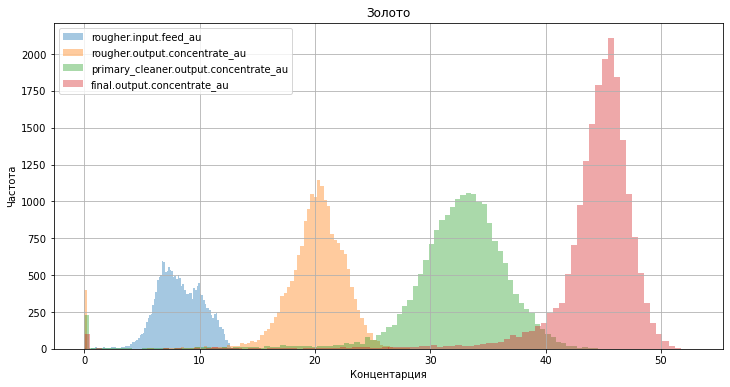

In [15]:
concentration_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

distribution_plot(gold_recovery_full, 100, 'Золото', concentration_au)

*Заметно, что концентрация золота увеличивается с каждым шагом. Можно увидеть 0, возможно это выбросы*

### Ag (серебро)

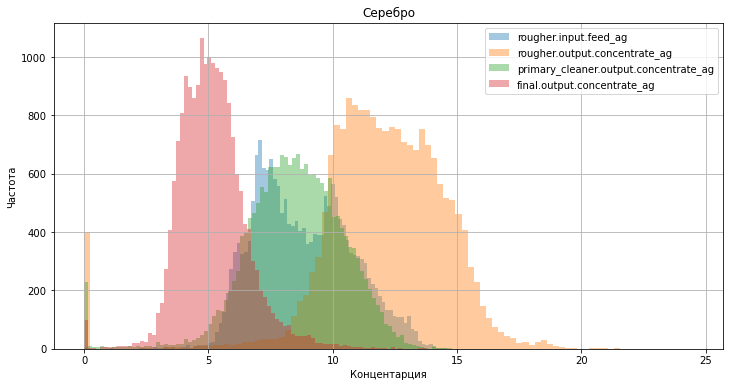

In [16]:
concentration_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']

distribution_plot(gold_recovery_full, 100, 'Серебро', concentration_ag)

*В случае серебра, то концентрация на финальном этапе наоборот уменьшилась, а самое большое значение было на стадии флотации. Данное уменьшение концентрации также соответствует логике процесса обогощения золотоносной руды*

### Pb (свинец)

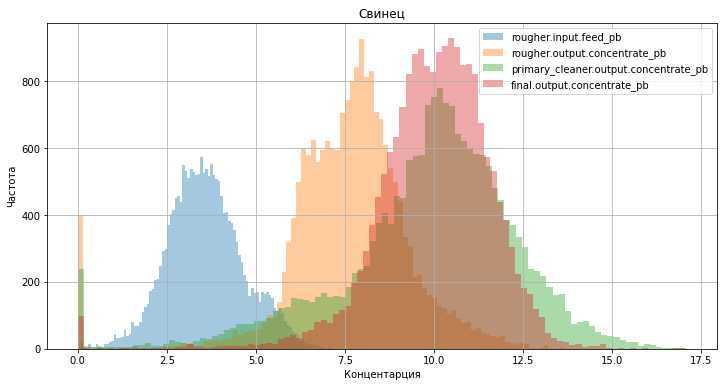

In [17]:
concentration_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

distribution_plot(gold_recovery_full, 100, 'Свинец', concentration_pb)

*Концентрация свинца растет с каждым шагом обработки, но вот после первичной обработки он не сильно изменяется, только уменьшается разброс*

## Вывод

*Провели анализ концентрации каждого элемента в зависимости этапа обработки. Можно заметить, что присутствует разброс, а также 0 значения, скорее всего это связано с особенностями тех. процессов, соотношений элементов в руде или ошибкой в замерах*

## 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках

In [18]:
def graph_plot(df1, df2, column, title, label):
    j = 0
    plt.figure(figsize=(12, 6))
    for i in df1, df2:
        sns.kdeplot(i[column], label=label[j])
        j += 1
    plt.legend()
    plt.title(title)
    plt.xlabel('Размер гранул')
    plt.ylabel('Частота')
    plt.grid(True)

### Флотация

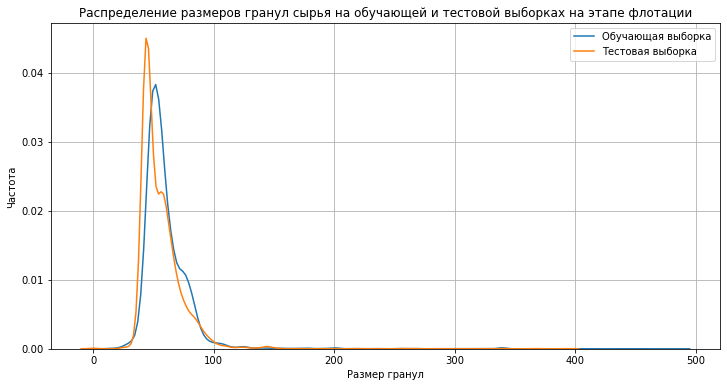

In [19]:
list_train_test = ['Обучающая выборка', 'Тестовая выборка']

graph_plot(gold_recovery_train, gold_recovery_test, 'rougher.input.feed_size', 'Распределение размеров гранул сырья на обучающей и тестовой выборках на этапе флотации', list_train_test)

### Первичная очистка

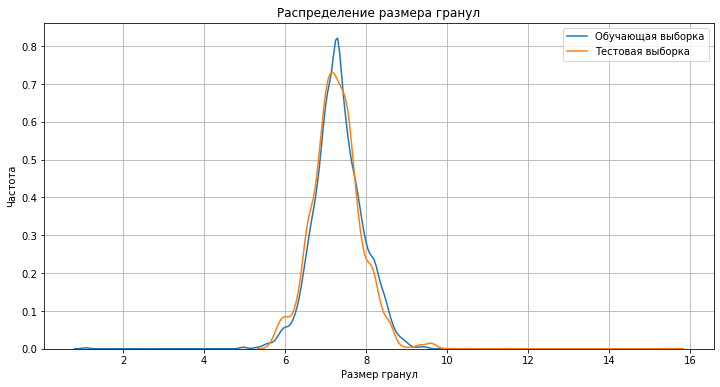

In [20]:
graph_plot(gold_recovery_train, gold_recovery_test, 'primary_cleaner.input.feed_size', 'Распределение размера гранул', list_train_test)

### Вывод

*Результаты распределения двух выборок отличаются не существенно, а также имеют нормальное распределение, значит на оценку модели в дальнейшем они слабо повлияют*

## 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [21]:
# Суммарная концентрация всех веществ на входе
gold_recovery_full['rougher_input_feed'] = (gold_recovery_full['rougher.input.feed_ag'] + 
                                 gold_recovery_full['rougher.input.feed_pb']+
                                 gold_recovery_full['rougher.input.feed_sol']+
                                 gold_recovery_full['rougher.input.feed_au'])


# Суммарная концентрация всех веществ на выходе
gold_recovery_full['rougher_output_concentrate'] = (gold_recovery_full['rougher.output.concentrate_ag'] + 
                                 gold_recovery_full['rougher.output.concentrate_pb']+
                                 gold_recovery_full['rougher.output.concentrate_sol']+
                                 gold_recovery_full['rougher.output.concentrate_au'])

# Суммарная концентрацию всех веществ после первичной очистки
gold_recovery_full['primary_cleaner_output_concentrate'] = (gold_recovery_full['primary_cleaner.output.concentrate_ag'] + 
                                         gold_recovery_full['primary_cleaner.output.concentrate_pb']+
                                         gold_recovery_full['primary_cleaner.output.concentrate_sol']+
                                         gold_recovery_full['primary_cleaner.output.concentrate_au'])

# Суммарная концентрацию всех веществ после финального этапа
gold_recovery_full['final_output_concentrate'] = (gold_recovery_full['final.output.concentrate_ag']+
                               gold_recovery_full['final.output.concentrate_pb']+
                               gold_recovery_full['final.output.concentrate_sol']+
                               gold_recovery_full['final.output.concentrate_au'])

Наглядно посмотрим на распределение концентрации всех веществ в зависимости от этапа обработки

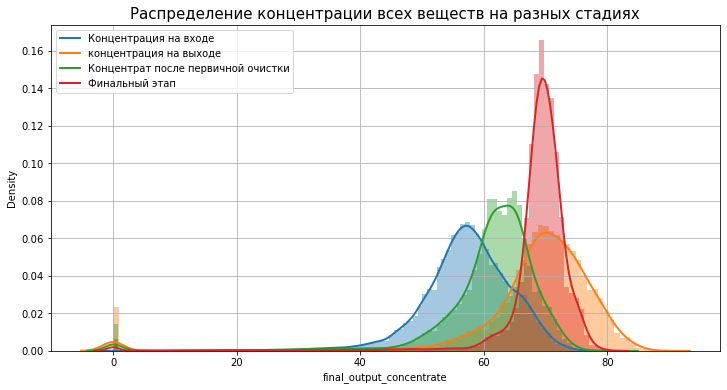

In [22]:
plt.figure(figsize=(12, 6))
plt.title('Распределение концентрации всех веществ на разных стадиях',fontsize=15)
sns.distplot(gold_recovery_full['rougher_input_feed'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Концентрация на входе"})
sns.distplot(gold_recovery_full['rougher_output_concentrate'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "концентрация на выходе"})
sns.distplot(gold_recovery_full['primary_cleaner_output_concentrate'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Концентрат после первичной очистки"})
sns.distplot(gold_recovery_full['final_output_concentrate'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Финальный этап"})
plt.legend()
plt.grid(True)
plt.show()

Видим, что с последующим шагом концентрация растет, проверим разброс на ящиках с усами на разных стадиях

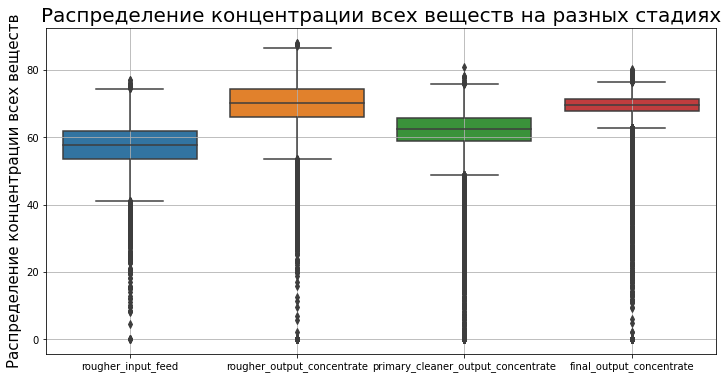

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = gold_recovery_full[['rougher_input_feed','rougher_output_concentrate','primary_cleaner_output_concentrate','final_output_concentrate']])
plt.title('Распределение концентрации всех веществ на разных стадиях', fontsize=20)
plt.ylabel('Распределение концентрации всех веществ', fontsize=15)
plt.grid(True)
plt.show()

*Видим аномалии в виде выбросов, которые могут повлиять на обучение моделей, а также присутствуют 0 значения*

In [24]:
# Функция для поиска нижних и верхних границ разброса
def levels(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3-Q1
    low_level = Q1 - 1.5*IQR
    high_level = Q1 + 1.5*IQR
    return low_level, high_level

In [25]:
# определим верхние и нижние границы, от которых начинаются аномальные значения
low_1, high_1 = levels(gold_recovery_full['rougher_input_feed'])
low_2, high_2 = levels(gold_recovery_full['rougher_output_concentrate'])
low_3, high_3 = levels(gold_recovery_full['primary_cleaner_output_concentrate'])
low_4, high_4 = levels(gold_recovery_full['final_output_concentrate'])

print(f"% аномальных значений на входе: {(gold_recovery_full.query('rougher_input_feed < @low_1').shape[0] / gold_recovery_full.shape[0]):.2%}")
print(f"% аномальных значений на выходе: {(gold_recovery_full.query('rougher_output_concentrate < @low_2').shape[0] / gold_recovery_full.shape[0]):.2%}")
print(f"% аномальных после этапа первичной очистки: {(gold_recovery_full.query('primary_cleaner_output_concentrate < @low_3').shape[0] / gold_recovery_full.shape[0]):.2%}")
print(f"% аномальных после финального этапа: {(gold_recovery_full.query('final_output_concentrate <= @low_4').shape[0] / gold_recovery_full.shape[0]):.2%}")

% аномальных значений на входе: 2.36%
% аномальных значений на выходе: 5.18%
% аномальных после этапа первичной очистки: 5.07%
% аномальных после финального этапа: 5.86%


*Объекты с экстремальными значениями в разных колонках могут пересекаться. Поэтому необходимо установить общую долю подобных значений в полной выборке.*

In [26]:
anomaly_input_feed = gold_recovery_full.query('rougher_input_feed < @low_1')
anomaly_rougher = gold_recovery_full.query('rougher_output_concentrate < @low_2')
anomaly_primary_cleaner = gold_recovery_full.query('primary_cleaner_output_concentrate < @low_3')
anomaly_final = gold_recovery_full.query('final_output_concentrate < @low_4')

anomaly = anomaly_input_feed.append([anomaly_rougher, anomaly_primary_cleaner, anomaly_final]).drop_duplicates().reset_index(drop=True)
print(f"% аномальных значений: {(anomaly.shape[0]/gold_recovery_full.shape[0]):.2%}")

% аномальных значений: 14.23%


*Доля экстремальных значений во всей выборке не существенна. Для того, чтобы избежать проблем с обучением и валидацией моделей удалим эти значения из обучающей и тестовой выборки.*

In [27]:
anomaly = anomaly['date'].to_list()
gold_recovery_train = gold_recovery_train.query('date not in @anomaly').reset_index(drop=True)
gold_recovery_test = gold_recovery_test.query('date not in @anomaly').reset_index(drop=True)

*Мы исследовали суммарную концентрацию всех веществ на разных стадиях и очистили обучающую и тестовую выборку от аномальных значений*

## Вывод

*Результаты анализа показали, что концентрация металлов на различных этапах обработки меняется в соответствии с тех. процессами. Проведя сравнение распределения размеров гранул сырья на обучающей и тестовой выборках можно сделать заключение, что существенного отличия нет. Нашли суммарную концентрация всех веществ на разных стадиях обработки и очистили выборки от аномальных значениях*

# 3. Модель

## 3.1. Напишите функцию для вычисления итоговой sMAPE

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она симметричная, потому что одинаково учитывает масштаб и целевого признака, и предсказания.

In [28]:
def sMAPE(target, predict):
    target = target.to_numpy()    
    sMAPE_rougher = 100/len(target[:, 0])*np.sum(2 * np.abs(target[:, 0] - predict[:, 0]) / (np.abs(target[:, 0]) + np.abs(predict[:, 0])))
    sMAPE_final = 100/len(target[:, 1])*np.sum(2 * np.abs(target[:, 1] - predict[:, 1]) / (np.abs(target[:, 1]) + np.abs(predict[:, 1])))
    sMAPE_result = (0.25*sMAPE_rougher) + (0.75*sMAPE_final)
    return sMAPE_result


# создаем метрику, которую мы будем максимизировать, подбирая подходящие параметры модели
sMAPE_scorer = make_scorer(sMAPE, greater_is_better = False)

Функция расчета sMAPE написана, а также добавлена как метрика для моделей

## 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке

In [29]:
def rfr_gridsearchcv(features, target, score):
    model = rfr()
    param_grid = {
        'n_jobs': [-1],
        'random_state': [42],
        'n_estimators': [500],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth' : np.arange(4,10)
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 5,  scoring = score)
    CV.fit(features, target)
    print('Лучшее значение метрики: {:.2f}'.format(-CV.best_score_))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 


# Линейная регрессия
def lr_gridsearchcv(features, target, score):
    model = lr()
    param_grid = {
        'copy_X': [True, False],
        'fit_intercept': [True, False],
        'normalize':[True,False]        
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, scoring = score)
    CV.fit(features, target)
    print('Лучшее значение метрики: {:.2f}'.format(-CV.best_score_))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 


# Ближайшие соседи
def knn_gridsearchcv(features, target, score):
    model = knr()
    param_grid = {
        'n_neighbors' : range(1,5,1),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, scoring = score)
    CV.fit(features, target)
    print('Лучшее значение метрики: {:.2f}'.format(-CV.best_score_))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 


def ml(model, features_train, target_train, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак выборки для обучения и тестирования.
    Функция обучает заданную модель по обучающей выборке и расчитывает метрику по тестовой выборке: "Итоговое sMAPE".
    '''
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mean_rougher = target_train.iloc[0].mean()
    mean_final = target_train.iloc[1].mean()
    lenght = target_valid.shape[0]
    r = np.full((lenght,1), mean_rougher)
    f = np.full((lenght,1), mean_final)
    predictions_mean = np.concatenate([r, f], axis=1)
    print(f'Средние значения эффективности обогощения чернового концентрата : {(mean_rougher):.2f}')
    print(f'Средние значения эффективности обогощения финального концентрата : {(mean_final):.2f}')
    print(f'Итоговое sMAPE: {(sMAPE(target_valid, predictions)):.2f}')
    print(f'Итоговое sMAPE (для константной модели): {(sMAPE(target_valid, predictions_mean)):.2f}')
    
    
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(16,10))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

#### Разобъём выборки по признакам и целевым признакам

In [30]:
# Разобьем данные обучающей выборки
features_train = gold_recovery_train[test_columns].drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]


# Разобьем данные тестовой выборки
features_valid = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
target_valid = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']]

#### Проведем масштабирование количественных признаков

In [31]:
columns_train = features_train.columns.to_list()
columns_valid = features_valid.columns.to_list()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_train[columns_train])
features_train[columns_train] = scaler.transform(features_train[columns_train])
features_valid[columns_valid] = scaler.transform(features_valid[columns_valid])

### Линейная регрессия

In [32]:
%%time
best_params_lr = lr_gridsearchcv(features_train, target_train, sMAPE_scorer)

Лучшее значение метрики: 8.73
Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Wall time: 750 ms


### RandomForestRegressor

Лучшее значение метрики: 7.62
Лучшие гиперпараметры:  {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
Wall time: 11min 8s


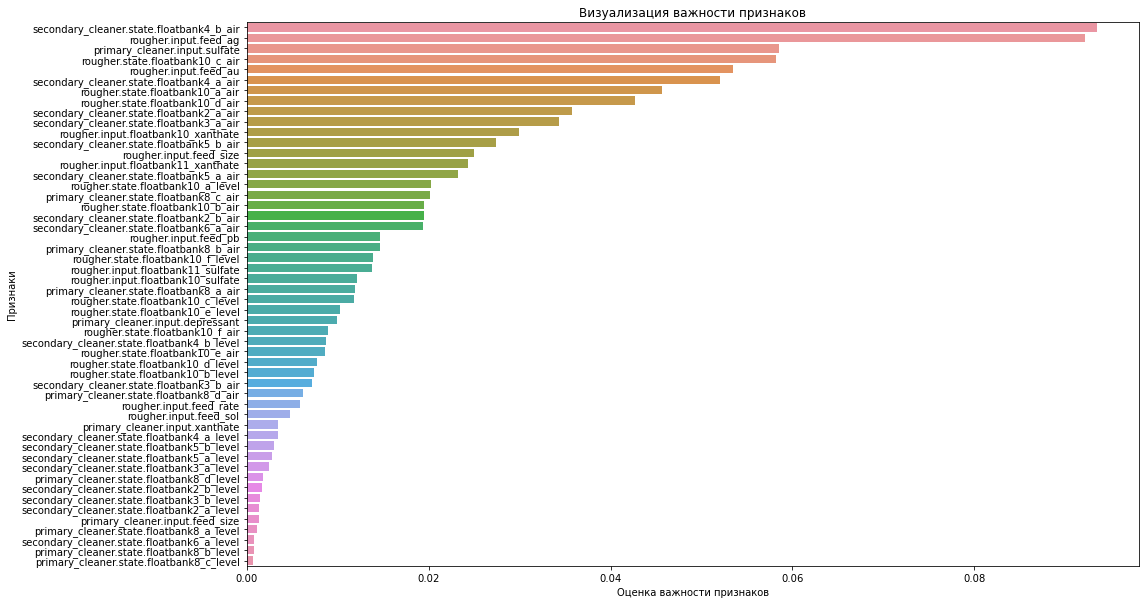

In [33]:
%%time
best_params_rfr = rfr_gridsearchcv(features_train, target_train, sMAPE_scorer)

model_rfr = rfr(**best_params_rfr)
model_rfr.fit(features_train, target_train)
chart_feature_imp(model_rfr)

### Алгоритм k-ближайших соседей

In [34]:
%%time
best_params_knn = knn_gridsearchcv(features_train, target_train, sMAPE_scorer)

Лучшее значение метрики: 9.51
Лучшие гиперпараметры:  {'algorithm': 'auto', 'n_neighbors': 4}
Wall time: 1min 24s


### Финальное тестирование

Наилучшее значение метрики на кросс-валидации показывает модель "cлучайного леса в регрессии". Обучим модель с помощью лучших гиперпараметров и протестируем ее на тестовой выборке. Для проверки итоговой модели на адекватность сравним значение итоговой sMAPE модели "cлучайного леса в регрессии" с итоговой sMAPE константной модели, предсказывающей среднее значение для всех объектов тестовой выборки

In [35]:
model_rfr = rfr(**best_params_rfr)
ml(model_rfr, features_train, target_train, features_valid, target_valid)

Средние значения эффективности обогощения чернового концентрата : 78.82
Средние значения эффективности обогощения финального концентрата : 78.05
Итоговое sMAPE: 6.31
Итоговое sMAPE (для константной модели): 12.15


*Итогое sMAPE модели "cлучайного леса в регрессии" оказалась меньше, чем sMAPE константной модели. Соответственно обученная модель точнее среднего значения, что подтверждает ее адекватность*

### Вывод по 3 шагу

Мы провели масштабирование признаков, а также обучили несколько моделей. Наиболее точный результат дала модель "случайного леса в регрессии"

## Итоговый вывод

*Были проанализированы данные и обработаны пропуски в признаках. Колонки были приведены к их соответствующим типам данных, а также была проведена проверка на наличие дубликатов. Мы убедились в корректности расчета эффективности обогащения, а также в том, что концентрация металлов на различных этапах очистки меняется в соответствии с технологическим процессом. Исследовав суммарную концентрацию всех веществ на разных стадиях мы обнаружили экстремальные значения, которые удалили из обучающей и тестовой выборки. В итоге были обучены модели и была выбрана наиболее точная из них - "cлучайный лес в регрессии".*